# Quality Assessment
Now it's your turn. Follow [the steps on the platform](https://platform.wbscodingschool.com/courses/data-science/9474/) and use what you've learnt to see how reliable the data is.

In [2]:
import pandas as pd

Load our cleaned DataFrames

In [3]:
# orders_cl.csv
path = "C:/Users/ruben/local_repos/WBS/Data_Science/Section_3/Data_Cleaning_Storytelling_with_Pandas_and_Matplotlib/data/clean_data/orders_cl.csv"
orders_cl = pd.read_csv(path)

# orderlines_cl.csv
path = "C:/Users/ruben/local_repos/WBS/Data_Science/Section_3/Data_Cleaning_Storytelling_with_Pandas_and_Matplotlib/data/clean_data/orderlines_cl.csv"
orderlines_cl = pd.read_csv(path)

# products_cl.csv
path = "C:/Users/ruben/local_repos/WBS/Data_Science/Section_3/Data_Cleaning_Storytelling_with_Pandas_and_Matplotlib/data/clean_data/products_cl.csv"
products_cl = pd.read_csv(path)

## 1.&nbsp; Define Pandas display format

In [5]:
# your code here
# This line sets the display format for floating point numbers to 2 decimal places
pd.set_option("display.float_format", lambda x: "%.2f" % x)

# This line sets the maximum number of rows displayed when using the `head()` or `tail()` functions to 1000
pd.set_option("display.max_rows", 1000)

## 2.&nbsp; Exclude unwanted orders

### 2.1. Keep only `Completed` orders

Make sure any of our changes won't affect the original DataFrame.

In [7]:
# your code here
actual_purchases_df = orders_cl.copy()

In [8]:
actual_purchases_df.state.value_counts()

Shopping Basket    117809
Completed           46605
Place Order         40883
Pending             14374
Cancelled            7233
Name: state, dtype: int64

I don't need `Shopping Basket`, `Place Order`, `Pending`, `Cancelled`, I will focus only on `Completed` ones.

In [9]:
actual_purchases_df = actual_purchases_df.loc[actual_purchases_df.state == "Completed", :]

I want to create a list of  `order_id`'s of the `Completed` orders that are useful, and I will use to filtering both, `orders_cl` and `orderlines_cl`.

In [10]:
actual_purchases_list = list(actual_purchases_df["order_id"])

We can now use the list of `order_id`'s to filter our DataFrames that have been cleaned. We will change the naming of the DataFrames from `_cl` to `_qu` to differentiate between the data that has undergone cleaning and the data that has undergone quality control.

In [11]:
orders_qu = orders_cl.loc[orders_cl["order_id"].isin(actual_purchases_list), :].copy()

In [12]:
orderlines_qu = orderlines_cl.loc[orderlines_cl["id_order"].isin(actual_purchases_list), :].copy()

### 2.2. Keep only the orders that are present in both: `orders` and `orderlines`

In [13]:
orders_lines_merged_df = orders_qu.merge(orderlines_qu, how="inner", left_on="order_id", right_on="id_order")

In [14]:
list_of_orders_in_both_df = list(orders_lines_merged_df["order_id"].unique())

In [15]:
orders_qu = orders_qu.loc[orders_qu["order_id"].isin(list_of_orders_in_both_df), :]
orderlines_qu = orderlines_cl.loc[orderlines_cl["id_order"].isin(list_of_orders_in_both_df), :]

## 3.&nbsp; Exclude orders with unknown products


**sku** – stock keeping unit: a unique identifier for each product

In [16]:
# your code here
known_skus_list = list(products_cl["sku"])

Let's have a look to see how many products in our `orderlines_qu` DataFrame are known and how many are unknown.

In [17]:
orderlines_qu.sku.isin(known_skus_list).value_counts()

True     61710
False      393
Name: sku, dtype: int64

We can't simply delete the rows containing unknown products. We need to remove the entirety of any order that contains an unknown product. 

The 1st step is to identify any order that contains an unknown product. Then find the `order_id` of these orders. Finally, filter these order numbers out of our `_qu` DataFrames.

In [20]:
orders_with_unknown_products_list = list(orderlines_qu.loc[~orderlines_qu.sku.isin(known_skus_list), "id_order"])

Now we can filter our DataFrame to exclude the `order_id`'s that contain unknown products

In [21]:
orders_qu = orders_qu.loc[~orders_qu["order_id"].isin(orders_with_unknown_products_list), :]
orderlines_qu = orderlines_qu.loc[~orderlines_qu["id_order"].isin(orders_with_unknown_products_list), :]

Let's have a quick check to make sure we're filtering both DataFrames the same. They should both contain the same number of unique `order_id`'s.

In [22]:
len(list(orders_qu["order_id"].unique())), len(list(orderlines_qu["id_order"].unique()))

(46172, 46172)

## 4.&nbsp; Explore the revenue from different tables

#### Step 1:
Create the `unit_price_total` as `orderlines.unit_price` * `orderlines.product_quantity`

In [23]:
# your code here
orderlines_qu_copy = orderlines_qu.copy()

In [24]:
orderlines_qu_copy["unit_price_total"] = orderlines_qu_copy["product_quantity"] * orderlines_qu_copy["unit_price"]

#### Step 2: 
Group by `order_id`, summarising by the sum of `unit_price_total`

In [25]:
# your code here
orderlines_qu_group_order_df = orderlines_qu_copy.groupby("id_order", as_index=False)["unit_price_total"].sum()

In [26]:
orderlines_qu_group_order_df.max()

id_order           527112.00
unit_price_total    13387.77
dtype: float64

### What is the average difference between `total_paid` and `unit_price_total`?

In [27]:
# your code here
orders_qu_copy = orders_qu.copy()

Let's merge our grouped `orderlines` table with the `orders` table, so we can calculate the differences in prices.

In [28]:
diff_df = orders_qu_copy.merge(orderlines_qu_group_order_df, left_on="order_id", right_on="id_order")

In [29]:
diff_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46172 entries, 0 to 46171
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          46172 non-null  int64  
 1   created_date      46172 non-null  object 
 2   total_paid        46172 non-null  float64
 3   state             46172 non-null  object 
 4   id_order          46172 non-null  int64  
 5   unit_price_total  46172 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 2.5+ MB


In [30]:
diff_df["difference"] = diff_df["total_paid"] - diff_df["unit_price_total"]
diff_df.head()

,order_id,created_date,total_paid,state,id_order,unit_price_total,difference
0,241423,2017-11-06 13:10:02,136.15,Completed,241423,129.16,6.99
1,242832,2017-12-31 17:40:03,15.76,Completed,242832,10.77,4.99
2,243330,2017-02-16 10:59:38,84.98,Completed,243330,77.99,6.99
3,245275,2017-06-28 11:35:37,149.00,Completed,245275,149.00,0.00
4,245595,2017-01-21 12:52:47,112.97,Completed,245595,105.98,6.99


Now that we know the difference for each order, we can compute the average.

In [31]:
diff_df.difference.mean().round(2)

4.25

### What is the distribution of these differences?

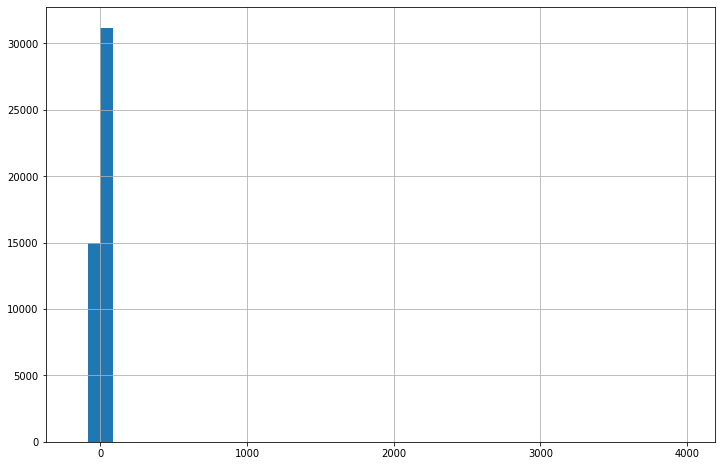

In [32]:
# your code here
diff_df.difference.hist(bins= 50, figsize=(12,8));

Looking at the spread of the data above, some of the difference must be due to corruption. Let's use `.describe()` to investigate the distribution further.

In [33]:
diff_df.difference.describe()

count   46172.00
mean        4.25
std        24.83
min      -165.00
25%         0.00
50%         4.99
75%         6.99
max      3984.99
Name: difference, dtype: float64

We can see from the our quartiles (0.00, 4.99, 6.99) that most of our data fits an expected pattern - free, 4.99, and 6.99 all seem like reasonable prices to assume as postage. However, look at the min and the max values, -165.00 and 3984.99, this can only occur due to corrupted data.

### If there are differences that you can’t explain: what should you do with these orders?
There's a rule of thumb, that anything: 
+ lower than the 25% quartile - (1.5 x interquartile range), or 
+ higher than the 75% quartile + (1.5 x interquartile range) 

is an outlier. Let's use this rule to try and exclude any corrupted data.

In [34]:
# your code here
# calculate the quartiles
Q1 = diff_df["difference"].quantile(0.25)
Q3 = diff_df["difference"].quantile(0.75)

# calculate the interquartile range
IQR = Q3-Q1

# filter the DataFrame to include only "non-outliers"
diff_no_outliers_df = diff_df.loc[(diff_df["difference"] >= (Q1 - 1.5*IQR)) & (diff_df["difference"] <= (Q3 + 1.5*IQR)), :]

Let's look at the distribution again to see the effect of removing the outliers.

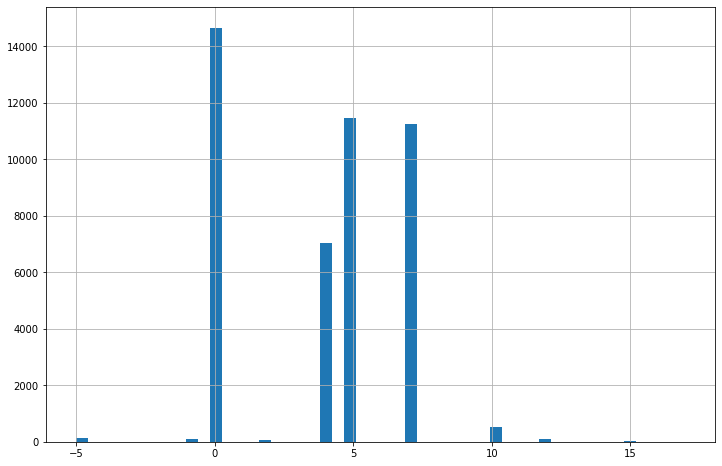

In [35]:
diff_no_outliers_df.difference.hist(bins= 50, figsize=(12,8));

This looks much more like what we would expect: a small difference, but nothing extreme.

Now we need to remove these orders with extreme differences from our `orders_lines_merged` DataFrame.

In [36]:
normal_diff_list = list(diff_no_outliers_df["order_id"])

In [37]:
orders_qu = orders_qu.loc[orders_qu["order_id"].isin(normal_diff_list), :]
orderlines_qu = orderlines_cl.loc[orderlines_cl["id_order"].isin(normal_diff_list), :]

In [38]:
len(list(orders_qu["order_id"].unique())), len(list(orderlines_qu["id_order"].unique()))

(45418, 45418)

## 5.&nbsp; Save quality data

In [39]:
# path for quality data
path_quality_data = "C:/Users/ruben/local_repos/WBS/Data_Science/Section_3/Data_Cleaning_Storytelling_with_Pandas_and_Matplotlib/data/quality_data/"

In [40]:
orders_qu.to_csv(path_quality_data + "orders_qu.csv", index=False)

In [41]:
orderlines_qu.to_csv(path_quality_data + "orderlines_qu.csv", index=False)